In [1]:
# Importing Libraries and models for future use

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import metrics

In [3]:
# Import the train and test data

train_df = pd.read_csv("train_compete.csv") 
X_test = pd.read_csv("test_compete.csv")

train_df.head()

,Id,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
0,1,30,0,Non-Travel,Research & Development,2,3,Medical,571,3,...,3,0,12,2,11,7,6,7,4,1
1,2,36,0,Travel_Rarely,Research & Development,12,4,Life Sciences,1614,3,...,3,2,7,2,3,2,1,1,2,1
2,3,55,1,Travel_Rarely,Sales,2,1,Medical,842,3,...,3,0,12,3,9,7,7,3,5,1
3,4,39,0,Travel_Rarely,Research & Development,24,1,Life Sciences,2014,1,...,3,0,18,2,7,7,1,7,4,1
4,5,37,0,Travel_Rarely,Research & Development,3,3,Other,689,3,...,3,1,10,2,10,7,7,8,1,1


In [5]:
# Drop the columns using Feature Engineering which we will see in later steps

X = train_df.drop(['Attrition','Id','EmployeeNumber','Behaviour'],axis = 1)
Y = train_df['Attrition']
X_test_N = X_test.drop(['Id','EmployeeNumber','Behaviour'],axis = 1)

In [6]:
# Find object columns so as to transform or encode them in order to apply ML models on the data

s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


In [7]:
# Break off validation set from training data

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [8]:
from sklearn.preprocessing import LabelEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_test = X_test_N.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])
    label_X_test[col] = label_encoder.transform(X_test_N[col])  

In [9]:
# Apply MinMax Scalar to all features so as to tune the variables in similar scale
# This step helps in improving the model results and better fit model to the data given

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_minmax = min_max_scaler.fit_transform(label_X_train)
X_valid_minmax = min_max_scaler.transform(label_X_valid)
X_test_minmax = min_max_scaler.transform(label_X_test)

In [10]:
# Applying first model GridSearchCV to the given dataset and trying to find the best parameters to better tune the model

from sklearn.ensemble import RandomForestClassifier

n_estimators = [100, 200, 300, 500]
max_depth = [1, 5, 8, 15, 20, 25]
min_samples_split = [1, 1.5, 2, 5, 8]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split)

forest = RandomForestClassifier(random_state = 0)
gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 3, 
                      n_jobs = -1)

bestF = gridF.fit(X_train_minmax, y_train)
print(bestF.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   53.5s finished


{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [11]:
# Applying first model XGBClassifier to the given dataset and trying to find the best parameters to better tune the model

from xgboost import XGBClassifier

gamma = [0.01, 0.1, 0.5, 1]
max_depth = [1, 2, 5, 8, 10,12]
learning_rate = [0.1, 1, 2, 5, 10]

hyperF_XGB = dict(gamma = gamma, max_depth = max_depth,  
              learning_rate = learning_rate)

XGB = XGBClassifier(random_state = 0)
gridF_XGB = GridSearchCV(XGB, hyperF_XGB, cv = 5, verbose = 1, 
                      n_jobs = -1)

bestF_XGB = gridF_XGB.fit(X_train_minmax, y_train)
print(bestF_XGB.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   16.7s finished


{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 12}


In [12]:
# Applying first model GradientBoostingClassifier to the given dataset and trying to find the best parameters to better tune the model

from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [100, 200, 300, 500, 700, 1000]
max_depth = [1, 2, 5, 6, 8]
learning_rate = [0.01, 0.05, 0.1, 1, 2,]

hyperF_gb = dict(n_estimators = n_estimators, max_depth = max_depth,
             learning_rate = learning_rate)

gb = GradientBoostingClassifier(random_state = 0)
gridF_gb = GridSearchCV(gb, hyperF_gb, cv = 5, verbose = 1, 
                      n_jobs = -1)

bestF_gb = gridF_gb.fit(X_train_minmax, y_train)
print(bestF_gb.best_params_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  2.7min finished


{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}


In [13]:
# Applying first model svm to the given dataset and trying to find the best parameters to better tune the model

from sklearn import svm

C = [1, 2, 3, 4, 5, 6, 6.5, 7]
kernel = [ 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

hyperF_svm = dict(C = C, kernel = kernel,  
              gamma=gamma)

model_svm = svm.SVC(random_state=0)
gridF_svm = GridSearchCV(model_svm, hyperF_svm, cv = 5, verbose = 1, 
                      n_jobs = -1)

bestF_svm = gridF_svm.fit(X_train_minmax, y_train)
print(bestF_svm.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s


{'C': 7, 'gamma': 'scale', 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.0s finished


Validation Accuracy: 
0.9815950920245399

 Confusion Matrix:
[[155   6]
 [  0 165]]


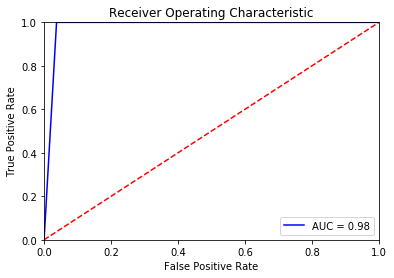

In [16]:
RF_reg = RandomForestClassifier(max_depth= 20, min_samples_split= 2, n_estimators= 300, random_state=0)
RF_reg.fit(X_train_minmax,y_train)

from sklearn import metrics
y_pred_class_train = RF_reg.predict(X_train_minmax)

y_pred_class = RF_reg.predict(X_valid_minmax)
print('Validation Accuracy: ')
print(metrics.accuracy_score(y_valid, y_pred_class))

print('\n Confusion Matrix:')
confusion = metrics.confusion_matrix(y_valid, y_pred_class)
print(confusion)

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_class)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix: 

[[157   4]
 [  0 165]]


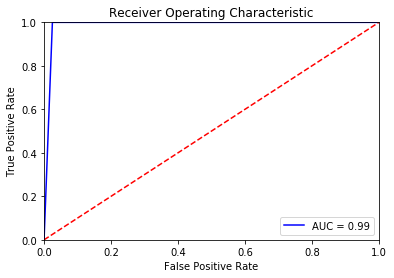

In [17]:
Gradient_reg = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 5, n_estimators= 500, random_state=0)
Gradient_reg.fit(X_train_minmax,y_train)

y_pred_class = Gradient_reg.predict(X_valid_minmax)

from sklearn import metrics

print('Confusion Matrix: \n')
confusion = metrics.confusion_matrix(y_valid, y_pred_class)
print(confusion)

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_class)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix: 

[[151  10]
 [  0 165]]


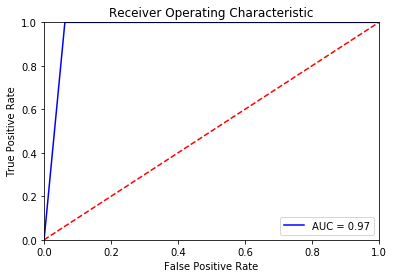

In [18]:
XGB_reg = XGBClassifier(gamma= 0.03,learning_rate= 0.18)
XGB_reg.fit(X_train_minmax,y_train)

y_pred_class = XGB_reg.predict(X_valid_minmax)

from sklearn import metrics

print('Confusion Matrix: \n')
confusion = metrics.confusion_matrix(y_valid, y_pred_class)
print(confusion)

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_class)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix: 

[[139  22]
 [  3 162]]


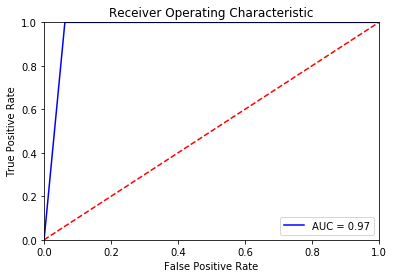

In [19]:
model_svm = svm.SVC(C= 7, gamma= 'scale', kernel= 'rbf',random_state=0,probability=True)
model_svm.fit(X_train_minmax,y_train)

y_pred_class = model_svm.predict(X_valid_minmax)

from sklearn import metrics

print('Confusion Matrix: \n')
confusion = metrics.confusion_matrix(y_valid, y_pred_class)
print(confusion)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
####### FEATURE IMPORTANCE #### ####
# rank the importance of features
# We can decide which parameters to drop based on this statistics

f_impt= pd.DataFrame(RF_reg.feature_importances_,index=X_train.columns)
f_impt = f_impt.sort_values(by=0,ascending=False)
f_impt.columns = ['feature importance']
f_impt

,feature importance
MonthlyIncome,0.094441
Age,0.081276
OverTime,0.066698
TotalWorkingYears,0.065955
DistanceFromHome,0.059260
YearsAtCompany,0.055698
StockOptionLevel,0.048087
PercentSalaryHike,0.044384
JobRole,0.042420
YearsInCurrentRole,0.041743


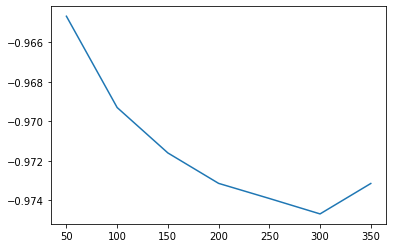

In [21]:
# Cross Validation can be useful in finding the average low MAPE score and to get the best parameters for our chosen ML model

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    # Replace this body with your own code
    my_pipeline = Pipeline(steps=[('model', RandomForestClassifier(n_estimators, random_state=0))])
    scores = -1 * cross_val_score(my_pipeline, X_train_minmax, y_train,
                              cv=10,
                              scoring='accuracy')

    return scores.mean()

results = {}
for i in range(1,8):
    results[50*i] = get_score(50*i)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [22]:
# Based on the accuracy and AUC score we have decided to use GradientBoostingClassifier as the final model to predict
# attrition rate on test dataset

attrition_percent = Gradient_reg.predict_proba(X_test_minmax)
dataset = pd.DataFrame({'Attrition': attrition_percent[:, 1]})

Id_col = train_df['Id']
Id_col.head()
dataset.insert(0, "Id",Id_col , True)

dataset.set_index('Id', inplace=True)
print (dataset)

     Attrition
Id            
1     0.001504
2     0.002382
3     0.003138
4     0.002045
5     0.000030
..         ...
466   0.210950
467   0.999702
468   0.842692
469   0.004683
470   0.008303

[470 rows x 1 columns]


In [ ]:
# For Feature Engineering we can plot many graphs showing distribution of individual variables against attrition rate 
# If the distribution is not normal or if it is skewed then we can use SQRT or LOG functions to fine tune them
# Also we can find the correlation graphs of pairs of varibales to find dependencies and if some of them are highly dependent
# on each other then we can drop or modify them to avoide repeated results.
# Plotting these graphs are very easy and will take much space to this notebook hence I havent shown them to keep it simple.

#Thanks for the review and I am happy for any comments or suggestions for this notebook